<a href="https://colab.research.google.com/github/dderaad/Hackathon-Summer-2021/blob/main/clfs_mk1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
# All of the paths for the relevant data sets are compiled into a list of urls
 
PATH = "https://raw.githubusercontent.com/dderaad/Hackathon-Summer-2021/main/"
files = [
         "prediction/prediction.csv", 
         "test_data/test_LABELS.csv", 
         "test_data/test_feature_names.csv", 
         "test_data/test_expression.csv.gz", 
         "train_data/train_labels.csv", 
         "train_data/train_feature_names.csv", 
         "train_data/train_expression.csv.gz"
         ]
urls = [PATH + x for x in files]
urls

['https://raw.githubusercontent.com/dderaad/Hackathon-Summer-2021/main/prediction/prediction.csv',
 'https://raw.githubusercontent.com/dderaad/Hackathon-Summer-2021/main/test_data/test_LABELS.csv',
 'https://raw.githubusercontent.com/dderaad/Hackathon-Summer-2021/main/test_data/test_feature_names.csv',
 'https://raw.githubusercontent.com/dderaad/Hackathon-Summer-2021/main/test_data/test_expression.csv.gz',
 'https://raw.githubusercontent.com/dderaad/Hackathon-Summer-2021/main/train_data/train_labels.csv',
 'https://raw.githubusercontent.com/dderaad/Hackathon-Summer-2021/main/train_data/train_feature_names.csv',
 'https://raw.githubusercontent.com/dderaad/Hackathon-Summer-2021/main/train_data/train_expression.csv.gz']

In [3]:
# The datasets are read into a python dictionary with their simplified path names as their keys
 
data_sets = {}
for url, file_name in zip(urls, files):
  data_sets[file_name] = pd.read_csv(url)
 
for data_set_name in data_sets:
  print(data_set_name, "\n", data_sets[data_set_name].head(5), "\n")

prediction/prediction.csv 
          age sample_id
0  51.048861  12fa2c69
1  53.905174  4d41ce5f
2  51.164177  82f6b2bb
3  52.086364  81161a04
4  53.272381  4370df33 

test_data/test_LABELS.csv 
   sample_id group
0  12fa2c69     C
1  4d41ce5f     A
2  82f6b2bb     C
3  81161a04     A
4  4370df33     B 

test_data/test_feature_names.csv 
               gene_id    symbol
0  ENSG00000000003.14    TSPAN6
1   ENSG00000000005.5      TNMD
2  ENSG00000000419.12      DPM1
3  ENSG00000000457.13     SCYL3
4  ENSG00000000460.16  C1orf112 

test_data/test_expression.csv.gz 
    ENSG00000000003.14  ENSG00000000005.5  ...  ENSG00000283698.1  ENSG00000283699.1
0              216130               3724  ...                  1                  1
1              196089                671  ...                 48                  0
2              455669             123617  ...                  1                  0
3               92006                400  ...                 28                  1
4         

In [4]:
labelled_training_data = pd.concat([data_sets["train_data/train_labels.csv"],
                                    data_sets["train_data/train_expression.csv.gz"] 
                                    ], axis=1)
labelled_training_data["sum"] = labelled_training_data.drop(["sample_id", "age", "group"], axis=1).sum(axis=1)
def sum_of_squares(x):
  return np.sum(np.power(x, 2))
labelled_training_data["squared_sum"] = labelled_training_data.drop(["sample_id", "age", "group"], axis=1).apply(sum_of_squares, axis=1)
labelled_training_data.head(10)

,sample_id,age,group,ENSG00000000003.14,ENSG00000000005.5,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16,ENSG00000000938.12,ENSG00000000971.15,ENSG00000001036.13,ENSG00000001084.10,ENSG00000001167.14,ENSG00000001460.17,ENSG00000001461.16,ENSG00000001561.6,ENSG00000001617.11,ENSG00000001626.14,ENSG00000001629.9,ENSG00000001630.15,ENSG00000002016.17,ENSG00000002079.12,ENSG00000002549.12,ENSG00000002586.18,ENSG00000002587.9,ENSG00000002726.20,ENSG00000002745.12,ENSG00000002746.14,ENSG00000002834.17,ENSG00000002919.14,ENSG00000002933.7,ENSG00000003096.13,ENSG00000003137.8,ENSG00000003147.17,ENSG00000003249.13,ENSG00000003400.14,ENSG00000003402.19,ENSG00000003436.14,ENSG00000003756.16,ENSG00000003987.13,...,ENSG00000283639.1,ENSG00000283644.1,ENSG00000283645.1,ENSG00000283646.1,ENSG00000283647.1,ENSG00000283648.1,ENSG00000283652.1,ENSG00000283653.1,ENSG00000283654.1,ENSG00000283656.1,ENSG00000283657.1,ENSG00000283659.1,ENSG00000283662.1,ENSG00000283663.1,ENSG00000283667.1,ENSG00000283669.1,ENSG00000283672.1,ENSG00000283673.1,ENSG00000283674.1,ENSG00000283676.1,ENSG00000283678.1,ENSG00000283679.1,ENSG00000283680.1,ENSG00000283682.1,ENSG00000283683.1,ENSG00000283684.1,ENSG00000283686.1,ENSG00000283689.1,ENSG00000283690.1,ENSG00000283691.1,ENSG00000283692.1,ENSG00000283693.1,ENSG00000283694.1,ENSG00000283695.1,ENSG00000283696.1,ENSG00000283697.1,ENSG00000283698.1,ENSG00000283699.1,sum,squared_sum
0,e1b41edc,55,A,62713,192,177091,135168,73181,23403,95254,165911,180606,368118,106610,320565,446433,702977,2844,418633,456407,84908,2371,319489,265113,12173,862,384,21100,1774586,152600,39672,15337,3921,370822,771708,27232,466489,44714,696054,193179,...,0,0,2,5323,0,1,35486,0,2799,0,241,49,10462,854,11023,0,36,0,17648,110,1,0,1,1,144,1335,2,5602,1,644,0,0,40,0,2886,8265,1,1,5235564783,8990370976265608984
1,234e8e31,62,A,124182,4870,121707,64541,49122,34556,104741,96063,74906,75056,16688,42124,12696,376101,33,151094,185958,12696,336,161551,480428,10300,2930,143,683,2520161,210741,575543,1419,21499,122818,332751,21867,179530,25954,284438,5256,...,0,1,1,95,0,1,26394,0,431,1,0,1,1062,0,3805,1,1,49,2559,107,3,0,0,0,68,722,3,912,0,121,0,0,0,69,335,3797,46,1,2114357564,4476259888071310206
2,df005c89,52,A,285105,385,132324,201131,112838,36724,283646,209734,160594,262819,47134,123372,74044,813642,1717,270598,567574,31926,577,397680,1272208,24440,4049,568,1382,7125969,78444,145272,39394,27243,288834,227256,39535,362362,67972,633312,8087,...,0,33,1,2260,1,1,33308,0,2032,54,67,1,1206,1194,1997,1,0,0,1881,208,2,0,0,1,1,4441,0,2334,20,163,1,1,66,47,3801,13738,48,1,4971388884,6311474188473869814
3,818437b2,42,A,277543,480,87439,113100,67013,34519,186042,146815,88497,150401,37532,153206,58714,377449,1751,175167,198559,22777,454,321259,953790,12415,1564,376,1881,1509005,115912,167189,13526,6493,183236,73275,33395,287364,52828,398867,3810,...,0,0,0,150819,2,96,48200,0,2126,19,0,0,577,1565,746,0,0,0,2713,738,2,0,0,0,192,2038,0,2832,1,253,1,0,1,0,3514,7445,48,0,3181270584,-8314476291165803792
4,8b7f7e4d,63,A,89628,288,89571,128793,59066,22495,153702,139875,124523,73579,40103,75714,25724,162708,443,100607,78755,18375,125,672231,768209,6387,1316,193,433,908969,108943,174869,11493,8066,91760,30703,33944,280800,38244,359759,3718,...,0,0,0,2318,0,231,51200,2,1432,0,2,0,192,701,504,1,41,1,1913,59,0,1,48,0,52,1478,1,825,0,147,0,0,17,0,3516,6047,1,0,2258139238,5105434734906032928
5,65846c93,77,A,361848,101,230960,224878,160255,67476,444287,741162,343287,238818,44584,170431,211562,741479,748,619979,987440,35049,1269,508909,2561747,44109,376985,253,8164,37416751,89608,249826,29593,56281,399831,493403,38547,500612,93731,454365,22194,...,1,14,1,5384,1,0,53927,1,3399,56,46,1,1901,1512,968,96,0,0,8915,331,9,0,350,0,274,6114,1,4179,0,100,0,50,1,0,3309,4211,399,0,7051294596,-5541518511290176650
6,3441dfca,50,A,84670,100,546749,282111,169075,40453,454057,636794,173055,268553,52323,229088,292262,450180,1317,558099,575118,37068,495,584224,1348411,16008,5381,201,2135,1926

In [5]:
labelled_testing_data = pd.concat([data_sets["test_data/test_LABELS.csv"],
                                    data_sets["test_data/test_expression.csv.gz"] 
                                    ], axis=1)
labelled_testing_data["sum"] = labelled_testing_data.drop(["sample_id", "group"], axis=1).sum(axis=1)
labelled_testing_data["squared_sum"] = labelled_testing_data.drop(["sample_id", "group"], axis=1).apply(sum_of_squares, axis=1)
labelled_testing_data.head(10)

,sample_id,group,ENSG00000000003.14,ENSG00000000005.5,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16,ENSG00000000938.12,ENSG00000000971.15,ENSG00000001036.13,ENSG00000001084.10,ENSG00000001167.14,ENSG00000001460.17,ENSG00000001461.16,ENSG00000001561.6,ENSG00000001617.11,ENSG00000001626.14,ENSG00000001629.9,ENSG00000001630.15,ENSG00000002016.17,ENSG00000002079.12,ENSG00000002549.12,ENSG00000002586.18,ENSG00000002587.9,ENSG00000002726.20,ENSG00000002745.12,ENSG00000002746.14,ENSG00000002834.17,ENSG00000002919.14,ENSG00000002933.7,ENSG00000003096.13,ENSG00000003137.8,ENSG00000003147.17,ENSG00000003249.13,ENSG00000003400.14,ENSG00000003402.19,ENSG00000003436.14,ENSG00000003756.16,ENSG00000003987.13,ENSG00000003989.16,...,ENSG00000283639.1,ENSG00000283644.1,ENSG00000283645.1,ENSG00000283646.1,ENSG00000283647.1,ENSG00000283648.1,ENSG00000283652.1,ENSG00000283653.1,ENSG00000283654.1,ENSG00000283656.1,ENSG00000283657.1,ENSG00000283659.1,ENSG00000283662.1,ENSG00000283663.1,ENSG00000283667.1,ENSG00000283669.1,ENSG00000283672.1,ENSG00000283673.1,ENSG00000283674.1,ENSG00000283676.1,ENSG00000283678.1,ENSG00000283679.1,ENSG00000283680.1,ENSG00000283682.1,ENSG00000283683.1,ENSG00000283684.1,ENSG00000283686.1,ENSG00000283689.1,ENSG00000283690.1,ENSG00000283691.1,ENSG00000283692.1,ENSG00000283693.1,ENSG00000283694.1,ENSG00000283695.1,ENSG00000283696.1,ENSG00000283697.1,ENSG00000283698.1,ENSG00000283699.1,sum,squared_sum
0,12fa2c69,C,216130,3724,158501,169431,72136,239413,1958773,405054,190105,111787,31063,132119,114077,294983,18470,258495,148914,69474,786,503892,2358522,35566,500,684,2020,749151,110511,365163,30185,80184,234757,45482,128455,1512878,564145,1401215,21474,710939,...,49,0,0,47729,230,0,37719,0,988,583,1514,1,0,12020,2525,0,35,1,49296,182,1,0,1,19,2636,8473,0,4080,1,160,0,151,23,2,2382,11417,1,1,4561267828,2381059769507683246
1,4d41ce5f,A,196089,671,96434,112703,67922,15916,209234,105360,192348,110960,41122,150374,51857,614533,512,273371,313928,34375,878,264207,931650,7122,763,430,1104,4700454,56400,99863,15356,11567,257478,72267,24287,291029,49599,476567,2662,291616,...,0,48,1,5936,127,0,28180,2,1057,350,148,0,314,1419,1290,88,0,0,933,110,23,0,0,1,182,2365,2,6720,0,186,0,1,0,0,1895,10016,48,0,3770706908,-4198507736703808574
2,82f6b2bb,C,455669,123617,217274,174936,88070,382592,817841,396940,397913,198589,73080,163311,215405,785858,9219,317722,122683,117439,471,758389,3025847,67874,1064,725,5031,1786045,187573,296825,20885,437483,221538,6445,163422,3317326,540599,1957008,20193,541206,...,1,129,0,7153,219,37,41025,61,3662,1,570,1,1,579,2529,0,0,0,4419,0,0,26,0,1,10781,4055,0,1508,0,71,1,0,0,1,2710,9278,1,0,7199846257,-3378365778775465552
3,81161a04,A,92006,400,271295,444488,242673,50198,359611,310289,783368,753853,105544,498159,581568,865985,750,699658,916791,88424,1048,957894,1046496,44048,695,265,3779,3697981,248832,115369,10474,10192,677240,272138,91950,972449,97360,1296196,8877,5546393,...,0,0,0,22805,0,1,51889,0,5224,348,430,100,1539,99,3198,0,1,0,3797,677,5,0,803,1,169,3070,1,2003,1,544,1,1,59,52,6067,27156,28,1,7739227713,4612354190919326272
4,4370df33,B,311516,108041,143606,134343,70622,261239,1046396,238826,187343,172348,30365,77754,223768,1220282,2142,282388,189056,62412,495,767745,2095274,20109,683,487,3525,974222,115994,260399,15503,287725,236076,8490,203558,1769920,915327,1330813,19770,747324,...,0,0,1,4033,152,0,39738,0,1255,0,192,77,1,904,1143,2,0,151,3637,0,0,0,0,0,493,11201,1,697,0,238,152,0,0,52,5699,5548,76,1,4660222992,3306390699397365626
5,0663bdbc,A,71028,1396,193283,185896,109605,69556,196118,330042,219307,280310,69168,488790,171483,529157,514,425181,285540,16484,889,965354,582746,53328,260316,381,2890,3058218,151071,791050,60694,7160,601284,320149,141483,791427,36465,427639,91264,7510602,...,0,52,2,424,4,262,184957,2,2010,85,65,0,1216,9084,1988,0,1,0,3716,8,2,1,0,1,100,1260,28,3653,1,377,0,0,152,105,3272,46137,52,0,4891126667,5504900665056465546
6,1e34b941,A,17383,383,133048,176637,105399,39615,3234

In [6]:
#labelled_testing_data.describe()

In [7]:
#labelled_training_data.describe()

In [42]:
from sklearn.dummy import DummyClassifier
from sklearn.dummy import DummyRegressor
clf_strategies = ["most_frequent", "uniform"]
reg_stratgies = ["mean", "median"]
dummy_classifiers = {f"Dummy Classifier ({i})": DummyClassifier(i) for i in clf_strategies}
dummy_regressors = {f"Dummy Regressor ({j})": DummyRegressor(j) for j in reg_stratgies}
dummy_classifiers.update(dummy_regressors)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

clfs = {
    #"Decision Tree": DecisionTreeClassifier(max_depth=3),
    "Random Forest": RandomForestRegressor(n_estimators=300, max_depth=5, max_features='sqrt', random_state=None, min_samples_leaf=2, ccp_alpha=0.0),
    #"AdaBoost": AdaBoostClassifier(),
    #"Linear SVM": SVC(kernel="linear", C=0.025),
    #"RBF SVM": SVC(gamma=2, C=1),
    #"Gaussian Process": GaussianProcessClassifier(1.0 * RBF(1.0))
}
 
classifiers = {}
#classifiers.update(dummy_classifiers)
classifiers.update(clfs)

In [43]:
# format: X, y
Xy_data_set = [
               labelled_training_data.drop(["sample_id", "group", "age"], axis=1),
               labelled_training_data["age"]
               ]
Xy_data_set
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(Xy_data_set[0])
Xy_data_set_scaled = Xy_data_set
Xy_data_set_scaled[0] = scaler.transform(Xy_data_set[0])
 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xy_data_set_scaled[0], Xy_data_set_scaled[1], test_size=0.15, random_state=None)
X_train

array([[-0.03188401,  0.42080762, -0.44313592, ..., -0.17576283,
         0.08714109, -1.75305411],
       [ 0.05675269,  0.73996077, -0.4619173 , ..., -0.23517129,
        -0.5522952 , -0.60892936],
       [-0.322708  , -0.36453638, -0.44407608, ..., -0.29457974,
        -0.5125247 , -0.46329537],
       ...,
       [ 0.48058627, -0.53819131, -0.40427864, ..., -0.29457974,
        -0.32062684,  0.22165772],
       [-0.56384802, -0.51488046, -0.33770129, ..., -0.23517129,
        -0.15737851,  0.86917514],
       [ 0.13946837,  0.80046403, -0.37311616, ..., -0.23517129,
         0.0362    ,  1.69987373]])

In [44]:
from sklearn.metrics import mean_squared_error
 
for clf_name in classifiers:
  classifiers[clf_name].fit(X_train, y_train)
  score = classifiers[clf_name].score(X_test, y_test)
  y_pred = classifiers[clf_name].predict(X_test)
  print(f'{clf_name}\nMSE: {mean_squared_error(y_test, y_pred)} \n{score}\n')

Random Forest
MSE: 157.29209818208406 
0.1864427315200945



In [11]:
prediction = classifiers["Random Forest"].predict(labelled_testing_data.drop(["sample_id", "group"], axis=1))
df = pd.concat([pd.Series(prediction, name="age"), labelled_testing_data["sample_id"]], axis=1)
df.to_csv("prediction\prediction.csv", index=False)
from google.colab import files
files.download("prediction\prediction.csv")
df

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,age,sample_id
0,52.065039,12fa2c69
1,51.950834,4d41ce5f
2,51.691268,82f6b2bb
3,52.195210,81161a04
4,52.015726,4370df33
...,...,...
960,51.278630,f71936c8
961,53.709947,063448fa
962,51.289578,3dd9a2df
963,51.997326,70120a3f


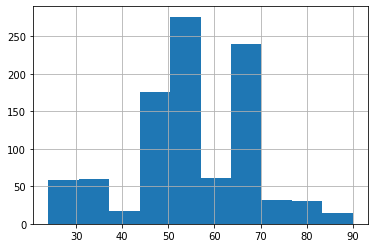

In [12]:
labelled_training_data["age"].hist()

In [19]:
# Grid Search
from sklearn.model_selection import GridSearchCV

# RandomForestRegressor(n_estimators=300, max_depth=5, max_features='sqrt', random_state=1, min_samples_leaf=2, ccp_alpha=0.3),

parameters = {
    "n_estimators": [100, 300, 500],
    "max_depth": [3, 5, 7],
    "max_features": ["sqrt"],
    "min_samples_leaf": [1, 2, 3, 4]
}

gs_clf = GridSearchCV(RandomForestRegressor(),
                      parameters,
                      scoring='neg_mean_absolute_error',
                      n_jobs=1,
                      verbose=3)


In [20]:
gs_clf.fit(Xy_data_set_scaled[0], Xy_data_set_scaled[1])

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=100, score=-10.722, total=   2.9s
[CV] max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV]  max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=100, score=-10.528, total=   2.8s
[CV] max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.8s remaining:    0.0s


[CV]  max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=100, score=-8.828, total=   2.8s
[CV] max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=100 
[CV]  max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=100, score=-9.720, total=   2.8s
[CV] max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=100 
[CV]  max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=100, score=-9.207, total=   2.8s
[CV] max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=300 
[CV]  max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=300, score=-10.602, total=   7.9s
[CV] max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=300 
[CV]  max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=300, score=-10.435, total=   7.8s
[CV] max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=300 
[CV]  max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=300, score=-8.787, total=   7.7s

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 36.6min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [21]:
print(f'Estimator {gs_clf.best_estimator_} was best with \nScore: {gs_clf.best_score_}\n')

Estimator RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False) was best with 
Score: -9.524824097879284

